In [11]:
import numpy as np

# MNIST

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset:

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
mnist = fetch_openml('mnist_784', version=1)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including the following:
* A DESCR key describing the dataset
* A data key containing an array with one row per instance and one column per feature
* A target key containing an array with the labels

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
X.shape, y.shape

((70000, 784), (70000,))

There are 70,000 images, and each image has 784 features. This is because each image is 28 × 28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s imshow() function:

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [7]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

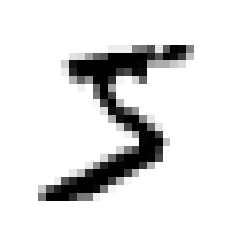

In [8]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

This looks like a 5, and indeed that’s what the label tells us:

In [9]:
y[0]

'5'

Note that the label is a string. Most ML algorithms expect numbers, so let’s cast y to integer:

In [12]:
y = y.astype(np.uint8)

In [13]:
y[0]

5

But wait! You should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [14]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). `Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row.` Shuffling the dataset ensures that this won’t happen.

### Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5. Let’s create the target vectors for this classification task:

In [15]:
y_train_5 = (y_train == 5) # True for all 5s, and False otherwise
y_test_5 = (y_test == 5)

Now let’s pick a classifier and train it. A good place to start is with a `Stochastic Gradient Descent (SGD) classifier`, using Scikit-Learn’s `SGDClassifier` class. This classifier has the advantage of being capable of handling very large datasets efficiently. `This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning)`, as we will see later. Let’s create an SGDClassifier and train it on the whole training se

In [16]:
from sklearn.linear_model import SGDClassifier

In [17]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

## TIP

The `SGDClassifier` relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you should set the `random_state` parameter.

Now we can use it to detect images of Number 5.

In [18]:
sgd_clf.predict([some_digit])

array([ True])

The classifier guesses that this image represents a 5 (True). Looks like it guessed right in this particular case! Now, let's evaluate this model's performance.

### Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic. There are many performance measures available, so grab another coffee and get ready to learn many new concepts and acronyms!

### Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use cross-validation, just as you did in Chapter 2.

## Implementing CROSS-VALIDATION

> Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off the shelf. In these cases, you can implement cross-validation yourself. The following code does roughly the same thing as Scikit-Learn’s `cross_val_score()` function, and it prints the same result:

In [19]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.base import clone

In [20]:
StratifiedShuffleSplit??

Init signature:
StratifiedShuffleSplit(
    n_splits=10,
    *,
    test_size=None,
    train_size=None,
    random_state=None,
)
Source:        
class StratifiedShuffleSplit(BaseShuffleSplit):
    """Stratified ShuffleSplit cross-validator

    Provides train/test indices to split data in train/test sets.

    This cross-validation object is a merge of StratifiedKFold and
    ShuffleSplit, which returns stratified randomized folds. The folds
    are made by preserving the percentage of samples for each class.

    Note: like the ShuffleSplit strategy, stratified random splits
    do not guarantee that all folds will be different, although this is
    still very likely for sizeable datasets.

    Read more in the :ref:`User Guide <cross_validation>`.

    Parameters
    ----------
    n_splits : int, default=10
        Number of re-shuffling & splitting iterations.

    test_size : float or int, default=None
        If float, should be between 0.0 and 1.0 and represent the proportion
 

In [29]:
StratifiedKFold??

Init signature: StratifiedKFold(n_splits=5, *, shuffle=False, random_state=None)
Source:        
class StratifiedKFold(_BaseKFold):
    """Stratified K-Folds cross-validator

    Provides train/test indices to split data in train/test sets.

    This cross-validation object is a variation of KFold that returns
    stratified folds. The folds are made by preserving the percentage of
    samples for each class.

    Read more in the :ref:`User Guide <cross_validation>`.

    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.

        .. versionchanged:: 0.22
            ``n_splits`` default value changed from 3 to 5.

    shuffle : bool, default=False
        Whether to shuffle each class's samples before splitting into batches.
        Note that the samples within each split will not be shuffled.

    random_state : int or RandomState instance, default=None
        When `shuffle` is True, `random_state` affects the ordering of the
      

In [23]:
clone??

Signature: clone(estimator, *, safe=True)
Source:   
@_deprecate_positional_args
def clone(estimator, *, safe=True):
    """Constructs a new estimator with the same parameters.

    Clone does a deep copy of the model in an estimator
    without actually copying attached data. It yields a new estimator
    with the same parameters that has not been fit on any data.

    Parameters
    ----------
    estimator : {list, tuple, set} of estimator objects or estimator object
        The estimator or group of estimators to be cloned.

    safe : bool, default=True
        If safe is false, clone will fall back to a deep copy on objects
        that are not estimators.

    """
    estimator_type = type(estimator)
    # XXX: not handling dictionaries
    if estimator_type in (list, tuple, set, frozenset):
        return estimator_type([clone(e, safe=safe) for e in estimator])
    elif not hasattr(estimator, 'get_params') or isinstance(estimator, type):
        if not safe:
            return 

In [28]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_test_fold))
    

/home/owl/Documents/venv/tlfMaths3.6/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


> The StratifiedKFold class performs stratified sampling (as explained in Chapter 2) to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

Let’s use the `cross_val_score()` function to evaluate our `SGDClassifier` model, using K-fold cross-validation with three folds. Remember that K-fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds (see Chapter 2):

In [21]:
from sklearn.model_selection import cross_val_score

In [22]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a `very dumb classifier` that just classifies every single image in the “not-5” class:

In [24]:
from sklearn.base import BaseEstimator

In [25]:
BaseEstimator??

Init signature: BaseEstimator()
Source:        
class BaseEstimator:
    """Base class for all estimators in scikit-learn

    Notes
    -----
    All estimators should specify all the parameters that can be set
    at the class level in their ``__init__`` as explicit keyword
    arguments (no ``*args`` or ``**kwargs``).
    """

    @classmethod
    def _get_param_names(cls):
        """Get parameter names for the estimator"""
        # fetch the constructor or the original constructor before
        # deprecation wrapping if any
        init = getattr(cls.__init__, 'deprecated_original', cls.__init__)
        if init is object.__init__:
            # No explicit constructor to introspect
            return []

        # introspect the constructor arguments to find the model parameters
        # to represent
        init_signature = inspect.signature(init)
        # Consider the constructor parameters excluding 'self'
        parameters = [p for p in init_signature.parameters.values()

In [26]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Can you guess this model's accuracy? Let's find out:

In [27]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.

This demonstrates why `accuracy` is generally `not the preferred performance measure for classifiers`, especially when you are dealing with `skewed datasets` (i.e., when some classes are much more frequent than others).

## Confusion Matrix

A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. </br> 
For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the fifth row and third column of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. You could make predictions on the test set, but let’s keep it untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the `cross_val_predict()` function:

In [28]:
from sklearn.model_selection import cross_val_predict

In [29]:
cross_val_predict??

Signature:
cross_val_predict(
    estimator,
    X,
    y=None,
    *,
    groups=None,
    cv=None,
    n_jobs=None,
    verbose=0,
    fit_params=None,
    pre_dispatch='2*n_jobs',
    method='predict',
)
Source:   
@_deprecate_positional_args
def cross_val_predict(estimator, X, y=None, *, groups=None, cv=None,
                      n_jobs=None, verbose=0, fit_params=None,
                      pre_dispatch='2*n_jobs', method='predict'):
    """Generate cross-validated estimates for each input data point

    The data is split according to the cv parameter. Each sample belongs
    to exactly one test set, and its prediction is computed with an
    estimator fitted on the corresponding training set.

    Passing these predictions into an evaluation metric may not be a valid
    way to measure generalization performance. Results can differ from
    :func:`cross_validate` and :func:`cross_val_score` unless all tests sets
    have equal size and the metric decomposes over samples.

    R

In [30]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the `cross_val_score()` function, `cross_val_predict()` performs `K-fold cross-validation`, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a `clean prediction` for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

Now you are ready to get the confusion matrix using the `confusion_matrix()` function. Just pass it the target classes (y_train_5) and the predicted classes (y_train_pred):

In [32]:
type(y_train_pred), y_train_pred.shape

(numpy.ndarray, (60000,))

In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

* Each row in a confusion matrix represents an **actual class**, while each column represents a **predicted class**.
* The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called `true negatives`), while the remaining 687 were wrongly classified as 5s (`false positives`). 
* The second row considers the images of 5s (the positive class): 1,891 were wrongly classified as non-5s (`false negatives`), while the remaining 3,530 were correctly classified as 5s (`true positives`). 
* A `perfect classifier` would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [35]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**The confusion matrix gives you a lot of information, but sometimes you may prefer a more concise metric. An interesting one to look at is the accuracy of the positive predictions; this is called the `precision of the classifier`** (Equation 3-1).

**Equation 3-1. `Precision`** </br>
$$precision = \frac{TP}{TP + FP}$$

*TP* is the number of *true positives*, and *FP* is the number of *false positives*.

**A trivial way to have perfect precision is to make one single positive prediction and ensure it is correct (precision = 1/1 = 100%). But this would not be very useful, since the classifier would ignore all but one positive instance. So precision is typically used along with another metric named `recall`, _also called sensitivity or the true positive rate (TPR)_: this is the ratio of positive instances that are correctly detected by the classifier** (Equation 3-2).

**Equation 3-2. `Recall`** </br>
$$recall = \frac{TP}{TP + FN}$$

FN is, of course, the number of false negatives.

If you are confused about the confusion matrix, below figure may help.

![Confusion Matrix Image](images/confusion_matrix.png)

## Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [52]:
from sklearn.metrics import precision_score, recall_score

In [38]:
recall_score??

Signature:
recall_score(
    y_true,
    y_pred,
    *,
    labels=None,
    pos_label=1,
    average='binary',
    sample_weight=None,
    zero_division='warn',
)
Source:   
@_deprecate_positional_args
def recall_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary',
                 sample_weight=None, zero_division="warn"):
    """Compute the recall

    The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of
    true positives and ``fn`` the number of false negatives. The recall is
    intuitively the ability of the classifier to find all the positive samples.

    The best value is 1 and the worst value is 0.

    Read more in the :ref:`User Guide <precision_recall_f_measure_metrics>`.

    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.

    y_pred : 1d array-like, or label indicator array / sparse matrix
        Estimated targets as returned by a classifier

In [39]:
precision_score??

Signature:
precision_score(
    y_true,
    y_pred,
    *,
    labels=None,
    pos_label=1,
    average='binary',
    sample_weight=None,
    zero_division='warn',
)
Source:   
@_deprecate_positional_args
def precision_score(y_true, y_pred, *, labels=None, pos_label=1,
                    average='binary', sample_weight=None,
                    zero_division="warn"):
    """Compute the precision

    The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
    true positives and ``fp`` the number of false positives. The precision is
    intuitively the ability of the classifier not to label as positive a sample
    that is negative.

    The best value is 1 and the worst value is 0.

    Read more in the :ref:`User Guide <precision_recall_f_measure_metrics>`.

    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.

    y_pred : 1d array-like, or label indicator array / sparse 

In [41]:
precision_recall_curve??

Signature:
precision_recall_curve(
    y_true,
    probas_pred,
    *,
    pos_label=None,
    sample_weight=None,
)
Source:   
@_deprecate_positional_args
def precision_recall_curve(y_true, probas_pred, *, pos_label=None,
                           sample_weight=None):
    """Compute precision-recall pairs for different probability thresholds

    Note: this implementation is restricted to the binary classification task.

    The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
    true positives and ``fp`` the number of false positives. The precision is
    intuitively the ability of the classifier not to label as positive a sample
    that is negative.

    The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of
    true positives and ``fn`` the number of false negatives. The recall is
    intuitively the ability of the classifier to find all the positive samples.

    The last precision and recall values are 1. and 0. respectively and do not


In [42]:
precision_recall_fscore_support??

Signature:
precision_recall_fscore_support(
    y_true,
    y_pred,
    *,
    beta=1.0,
    labels=None,
    pos_label=1,
    average=None,
    warn_for=('precision', 'recall', 'f-score'),
    sample_weight=None,
    zero_division='warn',
)
Source:   
@_deprecate_positional_args
def precision_recall_fscore_support(y_true, y_pred, *, beta=1.0, labels=None,
                                    pos_label=1, average=None,
                                    warn_for=('precision', 'recall',
                                              'f-score'),
                                    sample_weight=None,
                                    zero_division="warn"):
    """Compute precision, recall, F-measure and support for each class

    The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
    true positives and ``fp`` the number of false positives. The precision is
    intuitively the ability of the classifier not to label as positive a sample
    that is negative.

   

In [43]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [44]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [47]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [49]:
3530/(3530 + 687), 3530/(3530 + 1891) # Precision and recall score if I consider TRUE as correct classification of 5.

(0.8370879772350012, 0.6511713705958311)

In [50]:
53892/(53892 + 1891), 53892/(53892 + 687) # Precision and recall score if I consider TRUE as correct classification of non-5.

(0.9661007833927899, 0.987412741164184)

**Now your 5-detector does not look as shiny as it did when you looked at its accuracy. When it claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s.**

It is often convenient to **combine precision and recall** into a single metric called the **`F1 score`**, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean of precision and recall (Equation 3-3). Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

**Equation 3-3. $F_1$** </br>
$$F_1 = \frac{TP}{TP + \frac{FN + FP}{2}}$$

To compute the F1 score, simply call the `f1_score()` function:

In [53]:
from sklearn.metrics import f1_score

In [54]:
f1_score??

Signature:
f1_score(
    y_true,
    y_pred,
    *,
    labels=None,
    pos_label=1,
    average='binary',
    sample_weight=None,
    zero_division='warn',
)
Source:   
@_deprecate_positional_args
def f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary',
             sample_weight=None, zero_division="warn"):
    """Compute the F1 score, also known as balanced F-score or F-measure

    The F1 score can be interpreted as a weighted average of the precision and
    recall, where an F1 score reaches its best value at 1 and worst score at 0.
    The relative contribution of precision and recall to the F1 score are
    equal. The formula for the F1 score is::

        F1 = 2 * (precision * recall) / (precision + recall)

    In the multi-class and multi-label case, this is the average of
    the F1 score of each class with weighting depending on the ``average``
    parameter.

    Read more in the :ref:`User Guide <precision_recall_f_measure_metrics>`.

    Parameters
  

In [55]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [59]:
type(y_train_5), y_train_5.shape

(numpy.ndarray, (60000,))

In [60]:
f1_score(y_train_5, y_train_perfect_predictions)

1.0

* The `F1 score` favors classifiers that have similar `precision and recall`. </br>
* `This is not always what you want`: in some contexts you mostly `care about precision`, and `in other contexts you really care about recall`. </br>
* `For example`, 
    * if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). 
    * On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).
    
`Unfortunately, you can’t have it both ways`: `increasing precision reduces recall, and vice versa`. This is called the `precision/recall trade-off`.

## Precision/Recall Trade-off

To understand this trade-off, let’s look at how the `SGDClassifier` makes its classification decisions. </br>
For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class. <br>
Figure 3-3 shows a few digits positioned from the lowest score on the left to the highest score on the right. Suppose the decision threshold is positioned at the central arrow (between the two 5s): you will find 4 true positives (actual 5s) on the right of that threshold, and 1 false positive (actually a 6). Therefore, with that threshold, the precision is 80% (4 out of 5). But out of 6 actual 5s, the classifier only detects 4, so the recall is 67% (4 out of 6). If you raise the threshold (move it to the arrow on the right), the false positive (the 6) becomes a true negative, thereby increasing the precision (up to 100% in this case), but one true positive becomes a false negative, decreasing recall down to 50%. Conversely, lowering the threshold increases recall and reduces precision.

![Precision/Recall Trade-Off](images/precision_recall_trade_off.png)